# Tree Build Benchmark with JIT

This notebook reimplements the ``benchmark_tree_jit.py`` script and adds visualisations to study how radix-tree build time scales with the particle count when using eager vs. JIT-compiled routines. We compare both the adaptive LBVH builder and the new fixed-depth builder (host + JIT paths) so you can see how padding the tree for accelerator-friendly shapes affects throughput.

## Setup

We import the Expanse tree builders, timing helpers, and standard scientific libraries.

In [1]:
import math
from typing import Dict, Iterable, List

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from yggdrax.tree import (
    build_fixed_depth_tree,
    build_fixed_depth_tree_jit,
    build_tree,
    build_tree_jit,
)
from dataclasses import dataclass
import time

@dataclass(frozen=True)
class TimingStats:
    mean: float
    std: float
    samples: np.ndarray


def generate_random_distribution(
    count: int,
    *,
    box_half_extent: float = 1.0,
    seed: int = 0,
) -> tuple[jnp.ndarray, jnp.ndarray, jax.Array]:
    key = jax.random.PRNGKey(seed)
    key_pos, key_mass = jax.random.split(key)
    positions = jax.random.uniform(
        key_pos,
        (count, 3),
        minval=-box_half_extent,
        maxval=box_half_extent,
    )
    masses = jax.random.uniform(key_mass, (count,), minval=0.1, maxval=1.0)
    return positions, masses, key


def time_callable(func, *args, warmup: int = 0, runs: int = 5, **kwargs) -> TimingStats:
    for _ in range(max(0, warmup)):
        out = func(*args, **kwargs)
        jax.tree_util.tree_map(
            lambda x: x.block_until_ready() if hasattr(x, "block_until_ready") else x,
            out,
        )

    samples = []
    for _ in range(max(1, runs)):
        start = time.perf_counter()
        out = func(*args, **kwargs)
        jax.tree_util.tree_map(
            lambda x: x.block_until_ready() if hasattr(x, "block_until_ready") else x,
            out,
        )
        samples.append(time.perf_counter() - start)
    samples_np = np.asarray(samples, dtype=float)
    return TimingStats(
        mean=float(samples_np.mean()),
        std=float(samples_np.std(ddof=0)),
        samples=samples_np,
    )

# Ensure 64-bit precision for Morton codes (mirrors package __init__)
jax.config.update("jax_enable_x64", True)

In [2]:
def _make_bounds(half_extent: float, dtype: jnp.dtype) -> tuple[jnp.ndarray, jnp.ndarray]:
    span = jnp.asarray(half_extent, dtype=dtype)
    bounds_min = jnp.array([-span, -span, -span], dtype=dtype)
    bounds_max = jnp.array([span, span, span], dtype=dtype)
    return bounds_min, bounds_max


def benchmark_tree_build(
    particle_counts: Iterable[int],
    *,
    tree_mode: str = "lbvh",
    leaf_size: int = 32,
    target_leaf_particles: int = 32,
    runs: int = 5,
    warmup_eager: int = 0,
    warmup_jit: int = 1,
) -> List[Dict[str, float]]:
    if tree_mode not in {"lbvh", "fixed_depth"}:
        raise ValueError("tree_mode must be 'lbvh' or 'fixed_depth'")

    results: List[Dict[str, float]] = []
    for count in particle_counts:
        if count <= 0:
            raise ValueError("particle count must be positive")
        positions, masses, _ = generate_random_distribution(count, box_half_extent=1.0)
        bounds = _make_bounds(1.0, positions.dtype)

        if tree_mode == "lbvh":
            eager = time_callable(
                build_tree,
                positions,
                masses,
                bounds,
                leaf_size=leaf_size,
                return_reordered=True,
                warmup=max(0, warmup_eager),
                runs=runs,
            )
            jitted = time_callable(
                build_tree_jit,
                positions,
                masses,
                bounds,
                leaf_size=leaf_size,
                return_reordered=True,
                warmup=max(1, warmup_jit),
                runs=runs,
            )
        else:
            eager = time_callable(
                build_fixed_depth_tree,
                positions,
                masses,
                bounds,
                target_leaf_particles=target_leaf_particles,
                return_reordered=True,
                warmup=max(0, warmup_eager),
                runs=runs,
            )
            jitted = time_callable(
                build_fixed_depth_tree_jit,
                positions,
                masses,
                bounds,
                target_leaf_particles=target_leaf_particles,
                return_reordered=True,
                warmup=max(1, warmup_jit),
                runs=runs,
            )

        results.append(
            {
                "tree_mode": tree_mode,
                "num_particles": float(count),
                "leaf_size": float(leaf_size),
                "target_leaf_particles": float(target_leaf_particles),
                "build_ms_eager": eager.mean * 1e3,
                "build_ms_jit": jitted.mean * 1e3,
                "build_speedup": eager.mean / jitted.mean if jitted.mean else math.inf,
            }
        )
    return results

In [ ]:
particle_counts = [2048, 4096, 8192, 16384, 32768, 131072]
leaf_size = 32
target_leaf_particles = 32
runs = 7

lbvh_results = benchmark_tree_build(
    particle_counts,
    tree_mode="lbvh",
    leaf_size=leaf_size,
    runs=runs,
    warmup_eager=0,
    warmup_jit=1,
)
fixed_results = benchmark_tree_build(
    particle_counts,
    tree_mode="fixed_depth",
    target_leaf_particles=target_leaf_particles,
    runs=runs,
    warmup_eager=0,
    warmup_jit=1,
)

results_by_mode = {
    "lbvh": lbvh_results,
    "fixed_depth": fixed_results,
}

results_by_mode

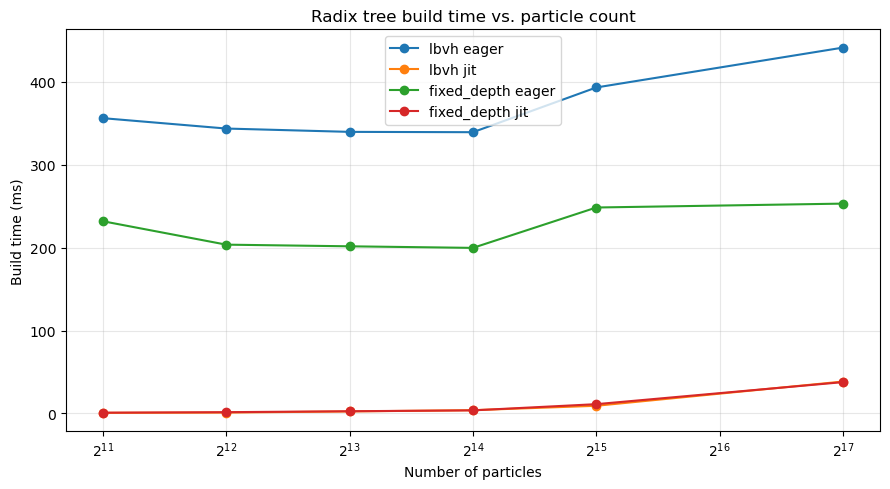

In [ ]:
plt.figure(figsize=(9, 5))
for mode, entries in results_by_mode.items():
    counts = [entry["num_particles"] for entry in entries]
    times_eager = [entry["build_ms_eager"] for entry in entries]
    times_jit = [entry["build_ms_jit"] for entry in entries]
    plt.plot(counts, times_eager, marker="o", label=f"{mode} eager")
    plt.plot(counts, times_jit, marker="o", label=f"{mode} jit")

plt.xlabel("Number of particles")
plt.ylabel("Build time (ms)")
plt.title("Radix tree build time vs. particle count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale("log", base=2)
plt.tight_layout()
plt.show()

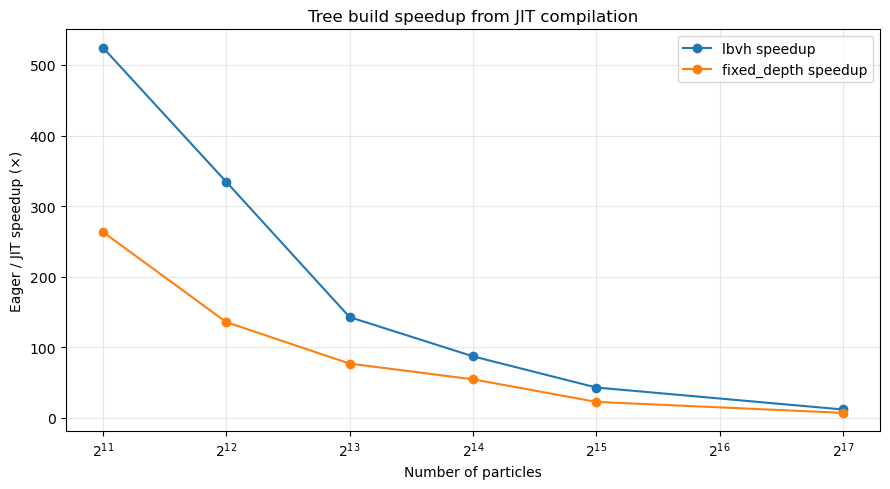

=== LBVH ===
N=  2048 | speedup = 524.65x
N=  4096 | speedup = 334.26x
N=  8192 | speedup = 142.48x
N= 16384 | speedup =  86.86x
N= 32768 | speedup =  42.65x
N=131072 | speedup =  11.47x

=== FIXED_DEPTH ===
N=  2048 | speedup = 263.21x
N=  4096 | speedup = 135.39x
N=  8192 | speedup =  76.56x
N= 16384 | speedup =  54.29x
N= 32768 | speedup =  22.24x
N=131072 | speedup =   6.70x



In [ ]:
plt.figure(figsize=(9, 5))
for mode, entries in results_by_mode.items():
    counts = [entry["num_particles"] for entry in entries]
    speedups = [entry["build_speedup"] for entry in entries]
    plt.plot(counts, speedups, marker="o", label=f"{mode} speedup")
plt.xlabel("Number of particles")
plt.ylabel("Eager / JIT speedup (×)")
plt.title("Tree build speedup from JIT compilation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale("log", base=2)
plt.tight_layout()
plt.show()

for mode, entries in results_by_mode.items():
    print(f"=== {mode.upper()} ===")
    for entry in entries:
        count = int(entry["num_particles"])
        speedup = entry["build_speedup"]
        print(f"N={count:6d} | speedup = {speedup:6.2f}x")
    print()